In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import zipfile
import shutil
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import random
import matplotlib.image as mpimg
import random
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch.nn.functional as F

In [2]:
import shutil

source_folder = '/content/drive/MyDrive/AirBurn/Zip data'  # Change this to your folder path
destination_folder = '/content/zip'  # Change this to your desired destination path in Colab

shutil.copytree(source_folder, destination_folder)

'/content/zip'

In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/zip/train_dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [4]:
import zipfile
zip_ref = zipfile.ZipFile("/content/zip/test_dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [5]:
df = pd.read_csv('/content/drive/MyDrive/AirBurn/train.csv')
df.head()

File Name        Class
0     1.jpg        other
1     2.jpg  bright dune
2     3.jpg        other
3     4.jpg       crater
4     5.jpg        other

In [ ]:
df.columns

Index(['File Name', 'Class'], dtype='object')

In [ ]:
df['Class'].unique()

array(['other', 'bright dune', 'crater', 'slope streak', 'dark dune',
       'swiss cheese', 'spider', 'impact ejecta'], dtype=object)

In [6]:
import os
image_directory = '/content/train_dataset'
df['File Name'] = df['File Name'].apply(lambda x: os.path.join(image_directory, x))
# df.to_csv('updated_file.csv', index=False)

In [7]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_images(df, num_images=4):
    fig,axs=plt.subplots(2, 2, figsize=(10, 10))

    for ax in axs.flat:
        random_iloc=random.randint(0, len(df) - 1)
        random_image=df['File Name'][random_iloc]
        img=mpimg.imread(random_image)
        ax.imshow(img)
        ax.set_title(df['Class'][random_iloc])
        ax.axis("off")
        print(f"Image shape: {img.shape}")
    plt.tight_layout()
    plt.show()

Image shape: (227, 227)
Image shape: (227, 227)
Image shape: (227, 227)
Image shape: (227, 227)


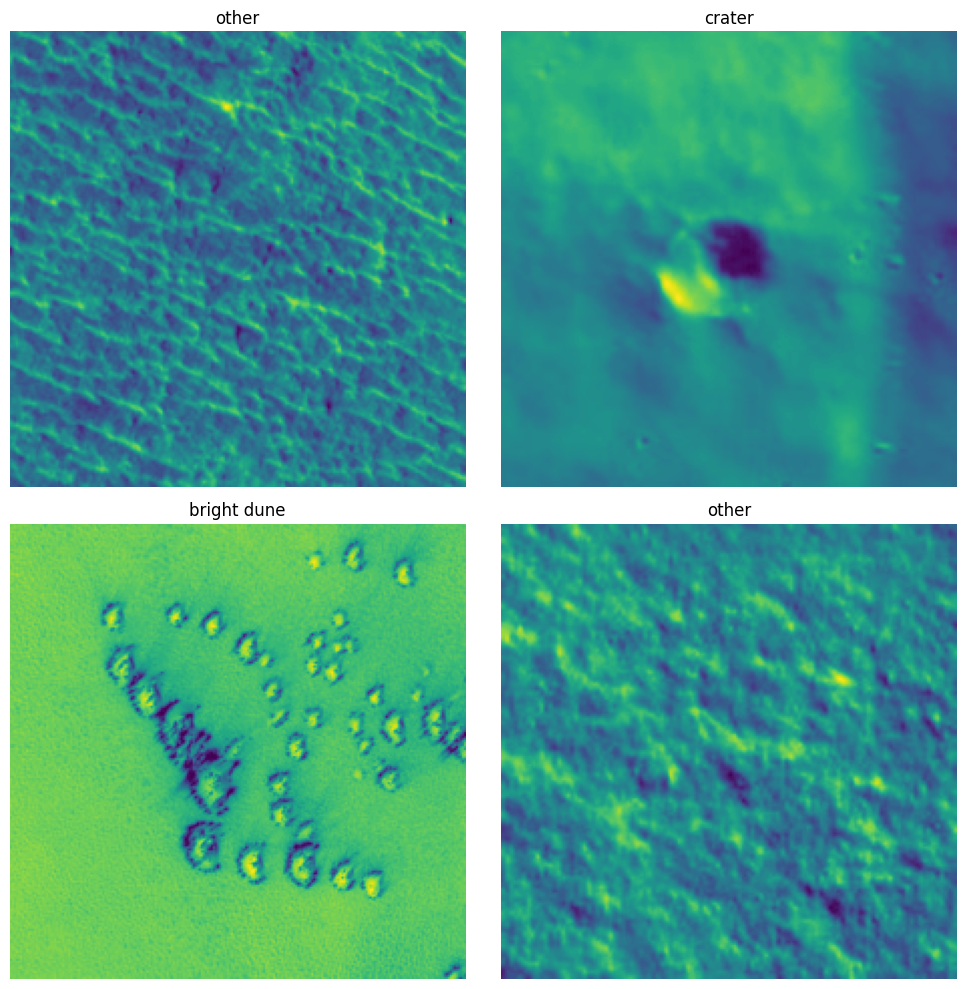

In [8]:
view_random_images(df)

In [9]:
train_df,test_df = train_test_split(df,test_size=0.1,random_state=1)

In [ ]:
print(f"Length of train data: {len(train_df)}")
print(f"Length of test data: {len(test_df)}")

Length of train data: 5580
Length of test data: 621


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='File Name',
    y_col='Class',
    target_size=(227, 227),
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

# val_images = train_generator.flow_from_dataframe(
#     dataframe=train_df,
#     x_col='File Name',
#     y_col='Class',
#     target_size=(227, 227),
#     class_mode='categorical',
#     batch_size=32,
#     shuffle=True
# )

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='File Name',
    y_col='Class',
    target_size=(227, 227),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5580 validated image filenames belonging to 8 classes.
Found 621 validated image filenames belonging to 8 classes.


# without dataaumgentation

In [10]:
labelencoder=LabelEncoder()
train_df['Class'] = labelencoder.fit_transform(train_df['Class'])
test_df['Class'] = labelencoder.fit_transform(test_df['Class'])

class MarsSurfaceDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data=csv_file
        self.transform=transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        img_name=self.data.iloc[idx,0]
        image = self.preprocess_image(img_name)
        label=self.data.iloc[idx,1]
        if self.transform:
            image=self.transform(image)
        return image,label
    def preprocess_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image_normalized = image / 255.0
        image_blurred = cv2.GaussianBlur(image_normalized, (5, 5), 0)
        image_equalized = cv2.equalizeHist((image_blurred * 255).astype(np.uint8))
        return image_equalized

transform=transforms.Compose([
    transforms.ToTensor()
])

train_dataset=MarsSurfaceDataset(csv_file=train_df,transform=transform)
test_dataset=MarsSurfaceDataset(csv_file=test_df,transform=transform)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1=nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=stride,padding=1)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.conv2=nn.Conv2d(out_channels, out_channels,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(out_channels)
        self.shortcut=nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        out+=self.shortcut(x)
        out=F.relu(out)
        return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
        self.layer2=ResidualBlock(64,128,stride=2)
        self.layer3=ResidualBlock(128,256,stride=2)
        self.layer4=ResidualBlock(256,512,stride=2)

    def forward(self, x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        return out

class Classifier(nn.Module):
    def __init__(self,num_classes):
        super(Classifier,self).__init__()
        self.fc = nn.Linear(512*7*7,num_classes)

    def forward(self, x):
        out=F.adaptive_avg_pool2d(x, (7, 7))
        out=out.view(out.size(0), -1)
        out=self.fc(out)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.upconv1=nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1)
        self.upconv2=nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1)
        self.upconv3=nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1)
        self.upconv4=nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1)
        self.upconv5=nn.ConvTranspose2d(32,1,kernel_size=4,stride=2,padding=1)

    def forward(self, x):
        # print(x.shape)
        out=self.upconv1(x)
        # print(out.shape)
        out=F.relu(out)
        # print(out.shape)
        out=self.upconv2(out)
        # print(out.shape)
        out=F.relu(out)
        # print(out.shape)
        out=self.upconv3(out)
        # print(out.shape)
        out=F.relu(out)
        out=self.upconv4(out)
        # print(out.shape)
        out=F.relu(out)
        out=self.upconv5(out)
        # print(out.shape)
        out=torch.sigmoid(out)
        out=F.interpolate(out, size=(227,227), mode='bilinear',align_corners=False)
        # print(out.shape)
        return out

class EncoderClassifierDecoder(nn.Module):
    def __init__(self, num_classes):
        super(EncoderClassifierDecoder,self).__init__()
        self.encoder=Encoder()
        self.classifier=Classifier(num_classes)
        self.decoder=Decoder()

    def forward(self, x):
        encoded=self.encoder(x)
        classification=self.classifier(encoded)
        reconstruction=self.decoder(encoded)
        # print(f" shape of re cons : {reconstruction.shape}")
        return classification,reconstruction

num_classes=8
model=EncoderClassifierDecoder(num_classes)
# inputs = torch.randn(32, 1, 227, 227)
# class_outputs, reconstruction_outputs = model(inputs)
print(f"TOTAL PARAMETERS : {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

TOTAL PARAMETERS : 7815273


In [12]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_classes =8
model=EncoderClassifierDecoder(num_classes).to(device)
criterion_classification=nn.CrossEntropyLoss()
criterion_reconstruction=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)
num_epochs=20
for epoch in range(num_epochs):
    model.train()
    running_loss=0.0
    correct=0
    total=0

    for images,labels in train_loader:
        images=images.to(device)
        labels=labels.to(device).long()
        class_outputs, reconstruction_outputs = model(images) #Forward Start
        loss_classification=criterion_classification(class_outputs,labels)
        loss_reconstruction=criterion_reconstruction(reconstruction_outputs,images)
        loss=loss_classification+loss_reconstruction
        optimizer.zero_grad() #BackPROP start
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        _,predicted=torch.max(class_outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    epoch_loss=running_loss/len(train_loader)
    epoch_accuracy=100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

model.eval()
with torch.no_grad(): #Eval
    correct=0
    total=0
    running_reconstruction_loss=0.0
    for images,labels in test_loader:
        images=images.to(device)
        labels=labels.to(device).long()
        class_outputs,reconstruction_outputs=model(images)
        loss_reconstruction=criterion_reconstruction(reconstruction_outputs,images)
        running_reconstruction_loss+=loss_reconstruction.item()
        _, predicted=torch.max(class_outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    accuracy=100*correct/total
    reconstruction_loss=running_reconstruction_loss/len(test_loader)

    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    print(f'Reconstruction Loss on the test images: {reconstruction_loss:.4f}')

Using device: cuda
Epoch [1/20], Loss: 1.4782, Accuracy: 61.68%
Epoch [2/20], Loss: 0.7980, Accuracy: 73.76%
Epoch [3/20], Loss: 0.6790, Accuracy: 77.53%
Epoch [4/20], Loss: 0.5888, Accuracy: 79.80%
Epoch [5/20], Loss: 0.4790, Accuracy: 83.62%
Epoch [6/20], Loss: 0.4083, Accuracy: 86.00%
Epoch [7/20], Loss: 0.3469, Accuracy: 88.30%
Epoch [8/20], Loss: 0.2867, Accuracy: 90.52%
Epoch [9/20], Loss: 0.2321, Accuracy: 92.74%
Epoch [10/20], Loss: 0.1861, Accuracy: 94.39%
Epoch [11/20], Loss: 0.1567, Accuracy: 95.30%
Epoch [12/20], Loss: 0.1665, Accuracy: 95.41%
Epoch [13/20], Loss: 0.1561, Accuracy: 95.52%
Epoch [14/20], Loss: 0.1200, Accuracy: 96.68%
Epoch [15/20], Loss: 0.1058, Accuracy: 97.46%
Epoch [16/20], Loss: 0.1156, Accuracy: 96.90%
Epoch [17/20], Loss: 0.0731, Accuracy: 98.39%
Epoch [18/20], Loss: 0.0698, Accuracy: 98.67%
Epoch [19/20], Loss: 0.1300, Accuracy: 96.95%
Epoch [20/20], Loss: 0.0753, Accuracy: 98.51%
Accuracy of the model on the test images: 81.32%
Reconstruction Loss o

In [13]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir=image_dir
        self.transform=transform
        self.image_files=[f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self,idx):
        img_name=self.image_files[idx]
        img_path=os.path.join(self.image_dir, img_name)
        image=Image.open(img_path).convert('L')
        if self.transform:
            image=self.transform(image)
        return image,img_name

transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
])

unlabeled_dataset=UnlabeledDataset(image_dir='/content/test_dataset',transform=transform)
unlabeled_loader=DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)


In [14]:
import pandas as pd

model.eval()
predictions=[]

with torch.no_grad():
    for images,img_names in unlabeled_loader:
        images=images.to(device)
        class_outputs,_=model(images)
        _,predicted_labels=torch.max(class_outputs, 1)
        for img_name,label in zip(img_names, predicted_labels):
            predictions.append((img_name,label.item()))

df=pd.DataFrame(predictions, columns=['Filename', 'PredictedLabel'])
df['PredictedLabel']=labelencoder.inverse_transform(df['PredictedLabel'])
df.to_csv('predictions_by_ENCODER_DECODER_CNNC_40_epochs_without_AUG.csv', index=False)


In [15]:
counter=1
recons = 0;
for images, labels in test_loader:
        images =images.to(device)
        labels =labels.to(device).long()
        class_outputs, recons = model(images)
        if counter==1:
          break;
recons.size()

torch.Size([32, 1, 227, 227])

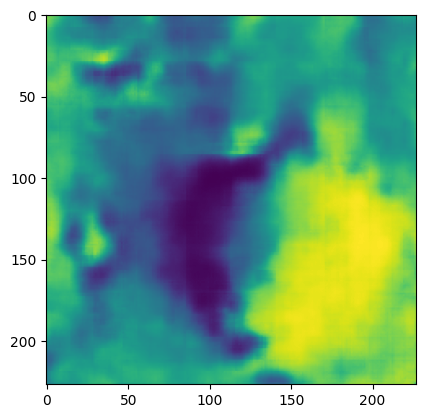

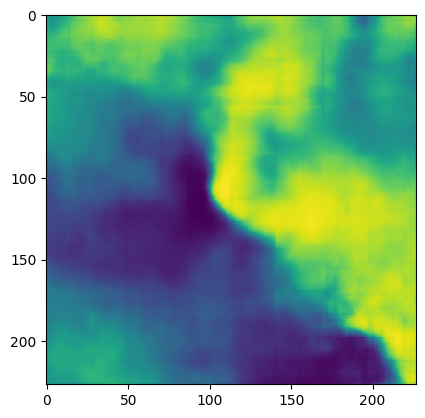

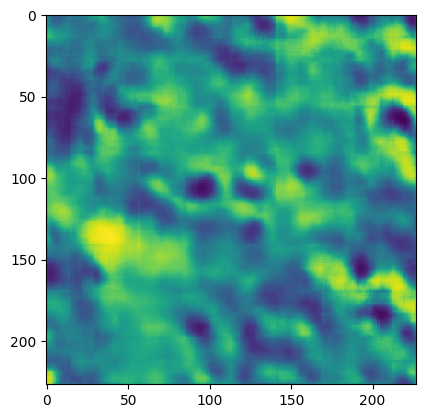

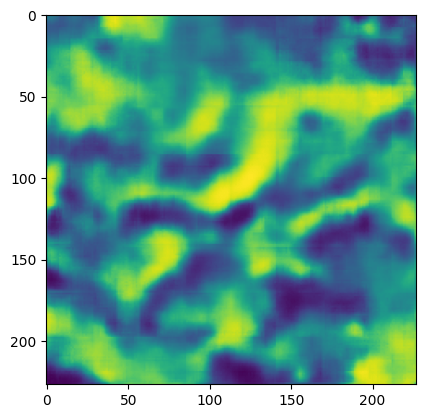

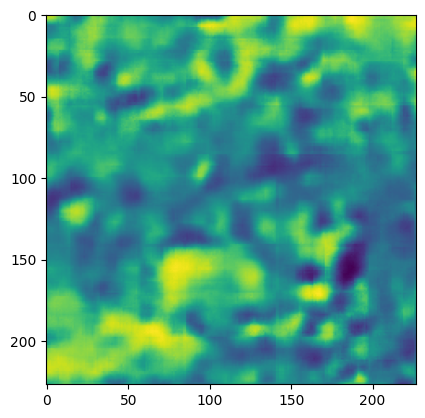

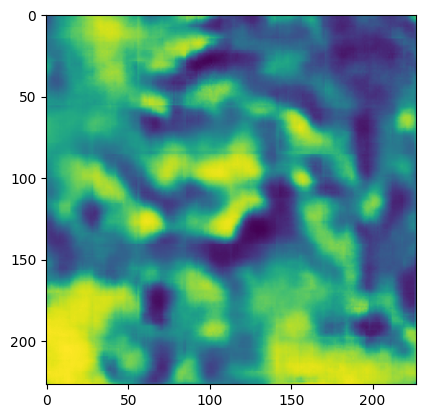

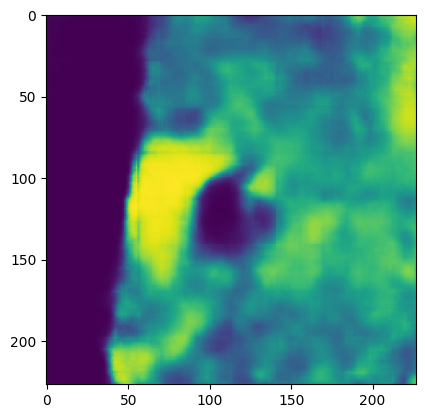

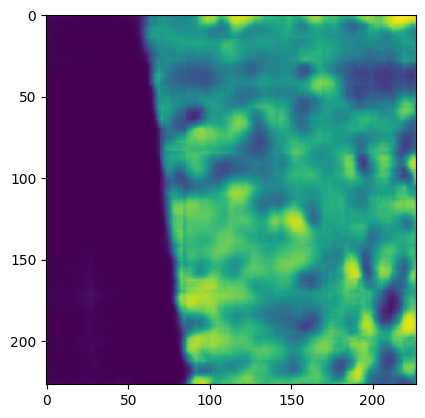

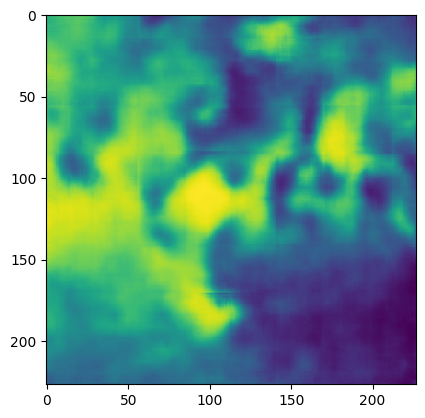

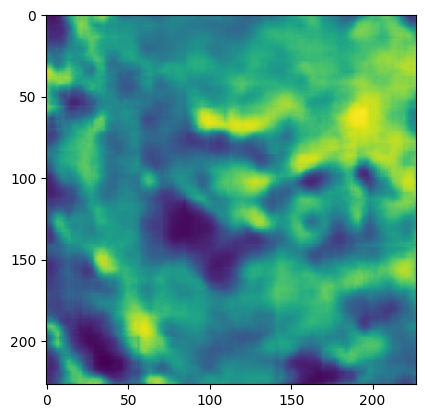

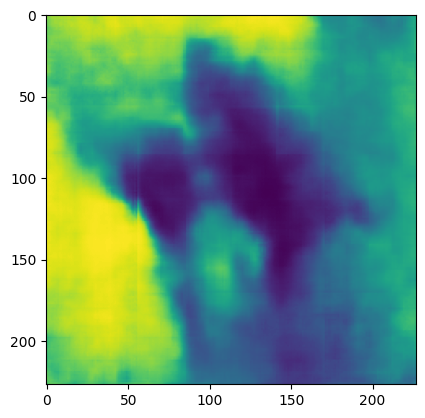

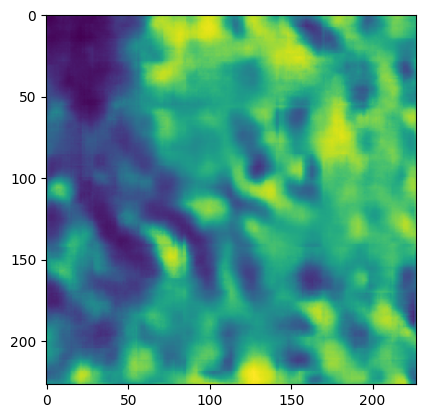

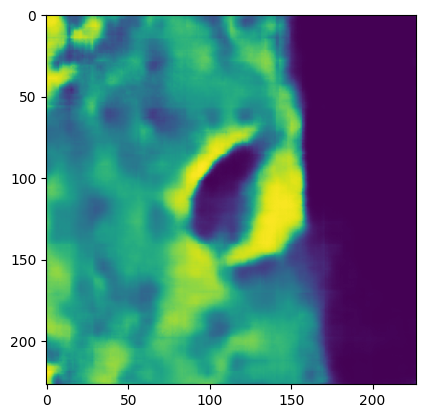

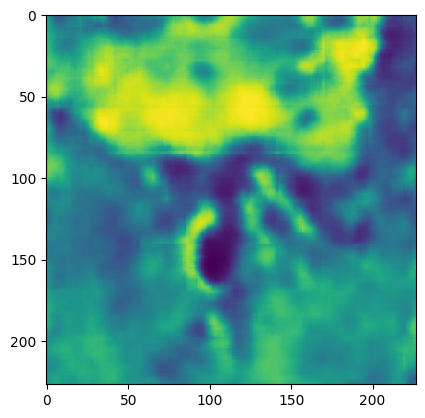

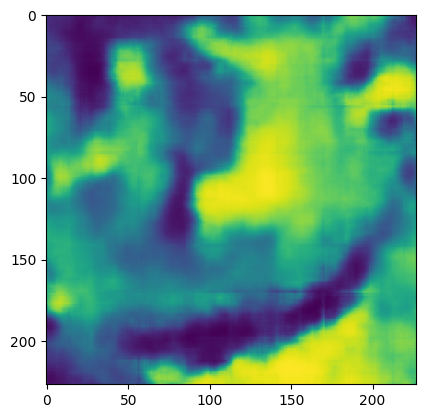

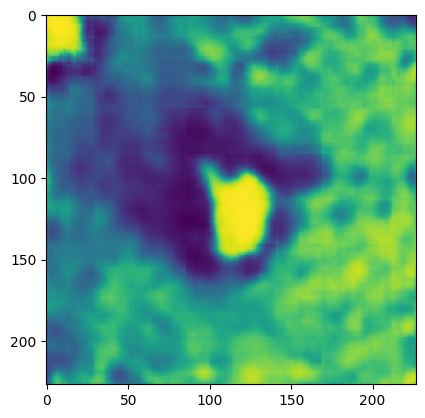

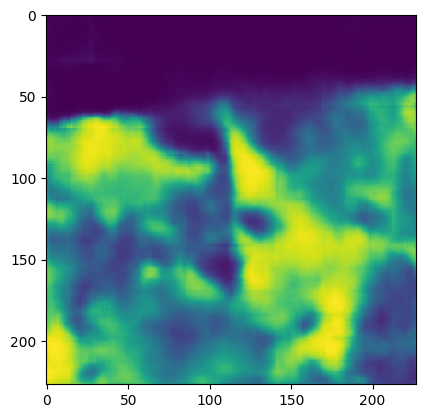

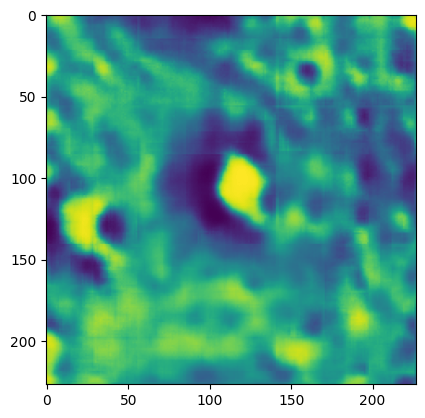

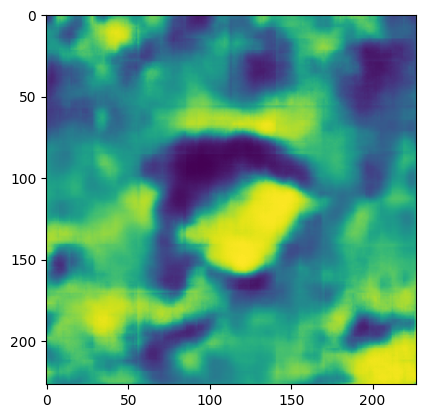

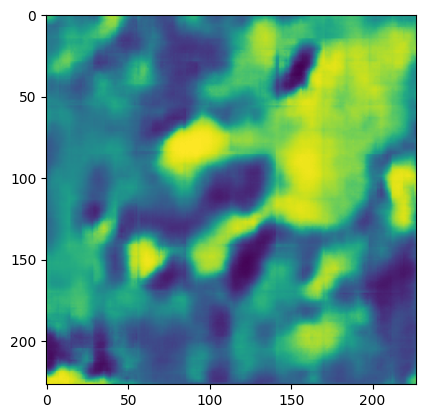

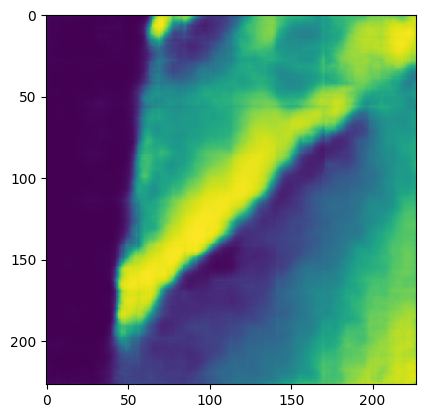

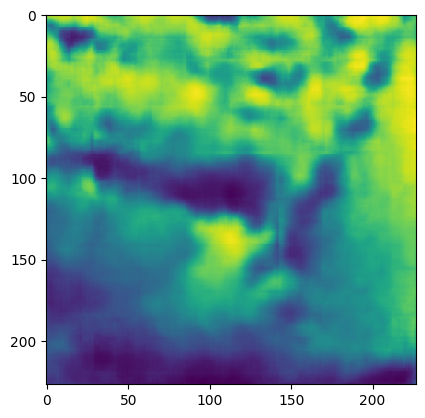

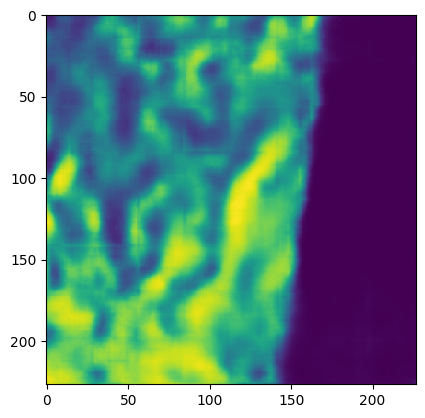

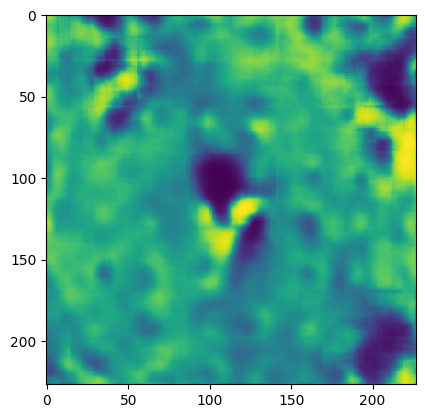

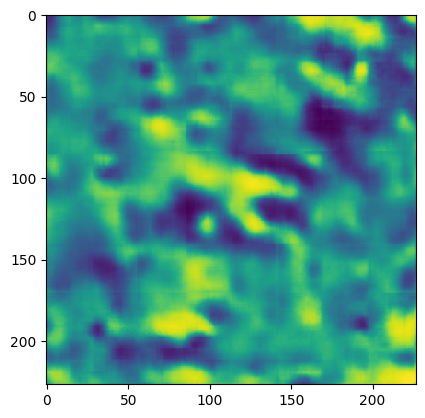

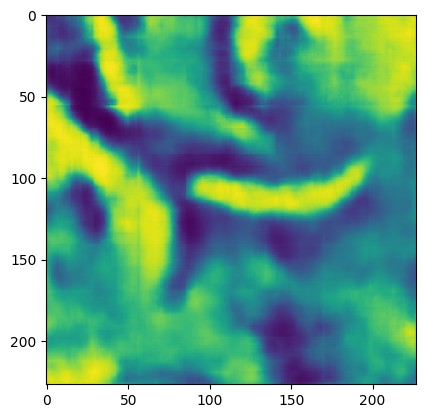

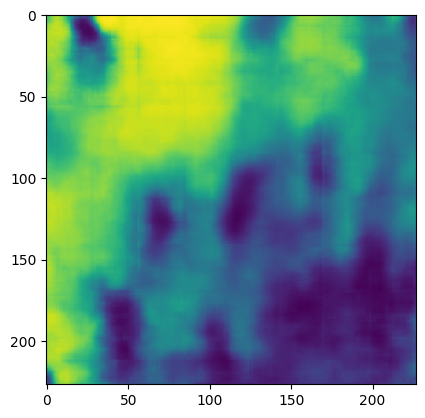

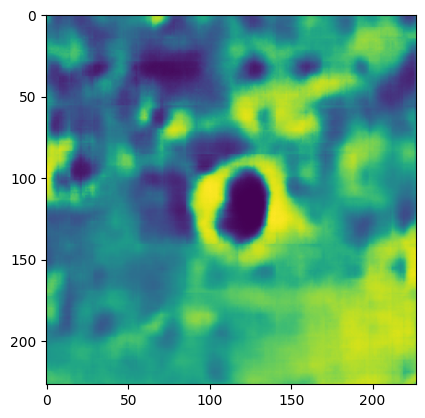

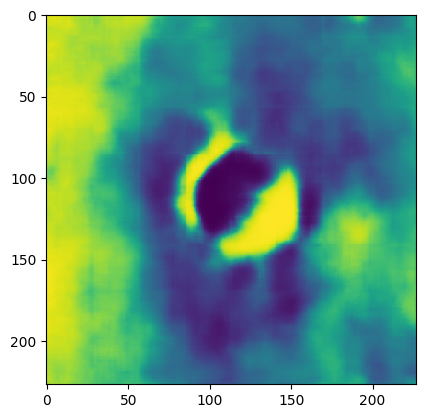

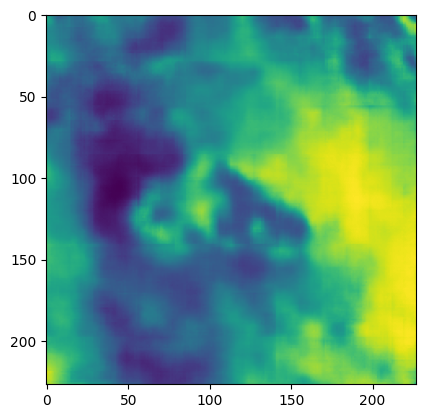

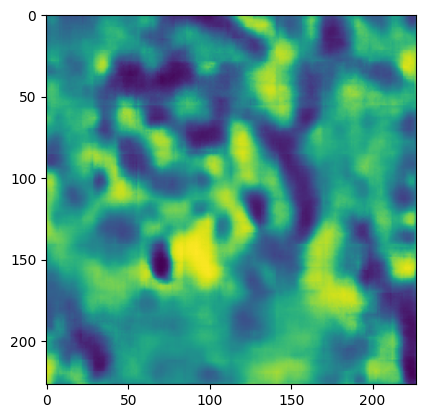

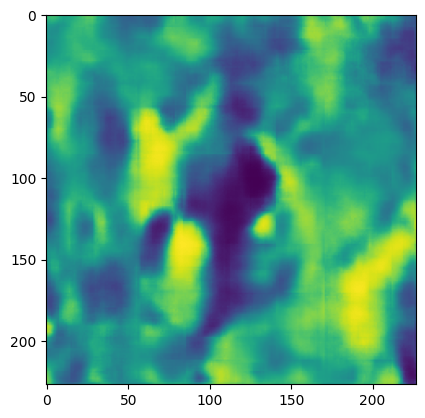

In [17]:
recons.size()
new = recons.squeeze(1)
for i in range (32):
  k = recons[i]
  k = k.squeeze(0)
  k = k.cpu()
  # Plotting the image
  k = k.detach().numpy()
  plt.imshow(k )
  plt.show()